In [1]:
import trafpy.generator as tpg
from trafpy.manager import Demand, RWA, SRPT, DCN
import config

Demand config file imported.


In [ ]:
# DEFINE FLOW-CENTRIC DISTRIBUTIONS
node_dist = tpg.gen_uniform_node_dist(config.ENDPOINT_LABELS, show_fig=True, print_data=False)

flow_size_dist, _ = tpg.gen_named_val_dist(dist='weibull',
                                       params={'_alpha': 1.4, '_lambda': 7000},
                                       show_fig=True,
                                       print_data=False,
                                       logscale=True,
                                       round_to_nearest=1,
                                       xlim=[1e2,1e12])

interarrival_time_dist, _ = tpg.gen_named_val_dist(dist='lognormal',
                                               params={'_mu': 7.4, '_sigma': 2},
                                               show_fig=True,
                                               print_data=False,
                                               logscale=True,
                                               xlim=[1e1,1e6])

In [ ]:
# DEFINE NUM_DEMANDS BY NUM_DEMANDS
num_demands = 1000

flow_centric_demand_data = tpg.create_demand_data(num_demands=num_demands,
                                                  eps=config.ENDPOINT_LABELS,
                                                  node_dist=node_dist,
                                                  flow_size_dist=flow_size_dist,
                                                  interarrival_time_dist=interarrival_time_dist,
                                                  print_data=True)
print('Flow data:\n{}'.format(flow_centric_demand_data))

In [ ]:
# DEFINE NUM_DEMANDS BY NETWORK LOAD
network_load_config = {'network_rate_capacity': 6000, 'target_load_fraction': 0.75}

flow_centric_demand_data = tpg.create_demand_data(network_load_config=network_load_config,
                                                  eps=config.ENDPOINT_LABELS,
                                                  node_dist=node_dist,
                                                  flow_size_dist=flow_size_dist,
                                                  interarrival_time_dist=interarrival_time_dist,
                                                  print_data=True)
print('Flow data:\n{}'.format(flow_centric_demand_data))

In [ ]:
load_rate = tpg.get_flow_centric_demand_data_load_rate(flow_centric_demand_data)
print('Load rate: {} Gbps'.format(load_rate))

In [ ]:
_demand_data = flow_centric_demand_data
print('demand data:\n{}\n'.format(_demand_data))

network = tpg.gen_simple_network(ep_label=config.ENDPOINT_LABEL,num_channels=config.NUM_CHANNELS)
demand = Demand(demand_data=_demand_data)
slots_dict = demand.get_slots_dict(slot_size=1000)

network_capacity = network.graph['max_nw_capacity']
print('Network capacity: {} Gbps'.format(network_capacity))
print('Num slots: {}'.format(len(slots_dict.keys())))
# print('Slots dict:\n{}'.format(_slots_dict))

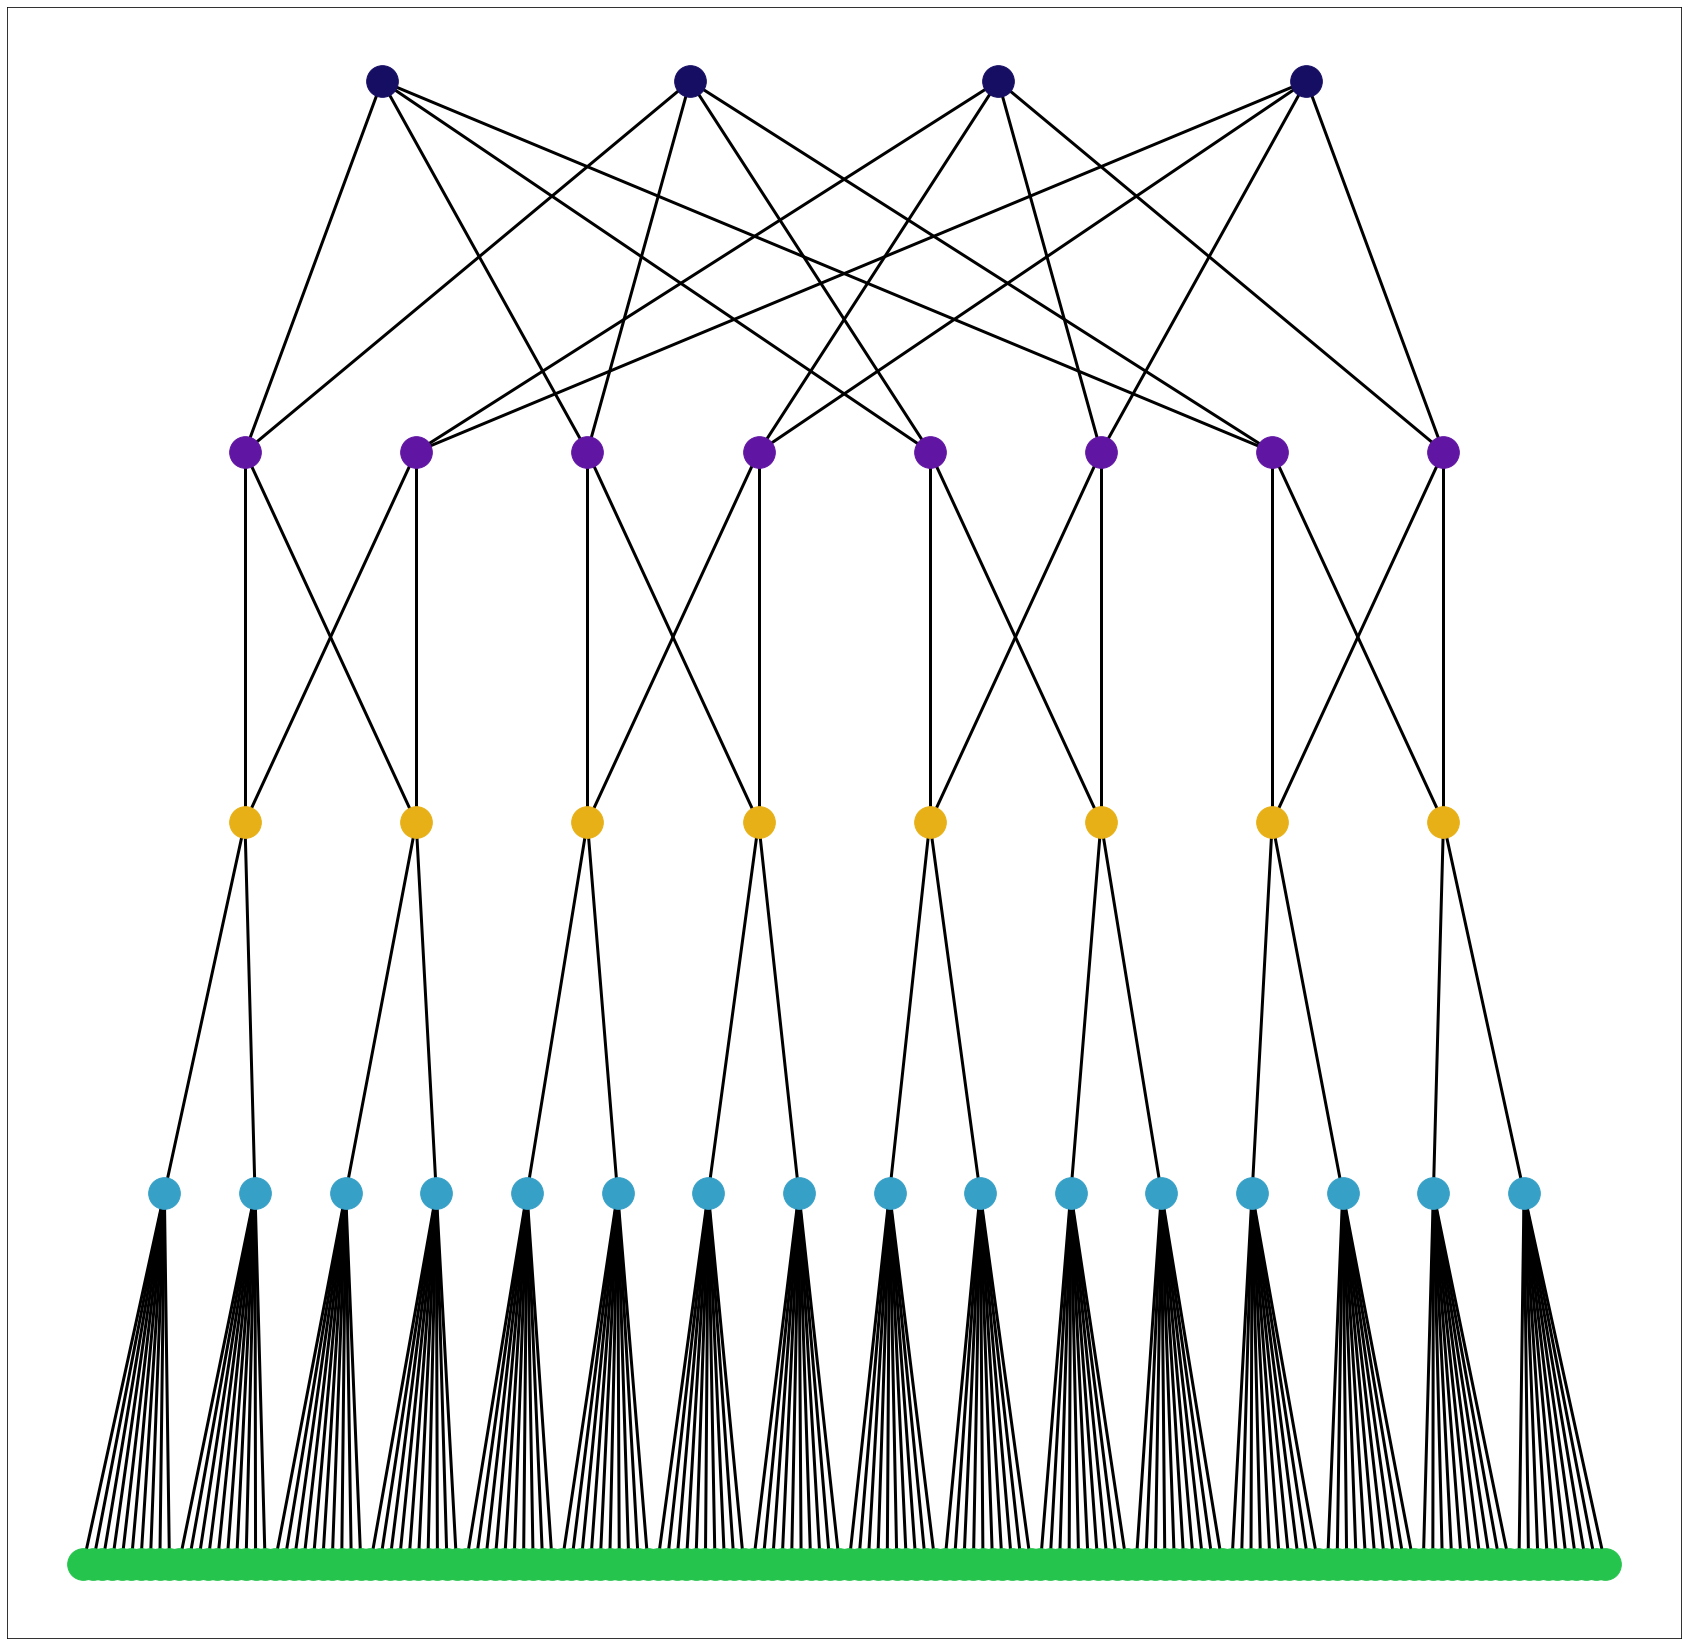

In [2]:
net = tpg.gen_fat_tree(k=4, N=10, num_channels=1)
fig = tpg.plot_network(net, draw_node_labels=False, network_node_size=1000, linewidths=1)

<Figure size 432x288 with 0 Axes>

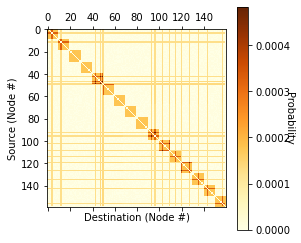

Time: 3.753812789916992 s


In [24]:
import time

start = time.time()

rack_prob_config = {'racks_dict': net.graph['rack_to_ep_dict'], 'prob_inter_rack': 0.7}
# rack_prob_config = None

num_skewed_nodes = int(0.1 * len(net.graph['endpoints']))
skewed_node_probs = [0.8/num_skewed_nodes for _ in range(num_skewed_nodes)]
# num_skewed_pairs = int(0.1 * (len(net.graph['endpoints'])**2-len(net.graph['endpoints'])))

# node_dist, _ = tpg.gen_uniform_node_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, show_fig=True, print_data=False)
node_dist, _ = tpg.gen_multimodal_node_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, show_fig=True, print_data=False, num_skewed_nodes=num_skewed_nodes, skewed_node_probs = skewed_node_probs)
# node_dist, _ = tpg.gen_multimodal_node_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, show_fig=True, print_data=False)
# node_dist, _ = tpg.gen_multimodal_node_pair_dist(net.graph['endpoints'], rack_prob_config=rack_prob_config, show_fig=True, print_data=False, num_skewed_pairs=num_skewed_pairs)

end = time.time()
print('Time: {} s'.format(end-start))

In [ ]:
sn, dn = tpg.gen_node_demands(eps=net.graph['endpoints'], node_dist=node_dist, num_demands=5000, rack_prob_config=rack_prob_config)

# find total number of intra- & inter-rack requests
ep_to_rack = net.graph['ep_to_rack_dict']
inter_rack_counter = 0
intra_rack_counter = 0
for src, dst in zip(sn, dn):
    if ep_to_rack[src] == ep_to_rack[dst]:
        intra_rack_counter += 1
    else:
        inter_rack_counter += 1
total_counts = intra_rack_counter + inter_rack_counter
        
print('Total counts: {}'.format(total_counts))
print('Num intra rack comms: {} ({}%)'.format(intra_rack_counter, intra_rack_counter*100/total_counts))
print('Num inter rack comms: {} ({}%)'.format(inter_rack_counter, inter_rack_counter*100/total_counts))


# plot_dict= {'Intra-rack': {'x_values': ['Uni DCN', 'Private DCN', 'Cloud DCN'], 'y_values': [intra_rack_counter*100/total_counts, 40, 80]},
#             'Inter-rack': {'x_values': ['Uni DCN', 'Private DCN', 'Cloud DCN'], 'y_values': [inter_rack_counter*100/total_counts, 60, 20]}}
plot_dict= {'Intra-rack': {'x_values': ['Priv DCN'], 'y_values': [intra_rack_counter*100/total_counts]},
            'Inter-rack': {'x_values': ['Priv DCN'], 'y_values': [inter_rack_counter*100/total_counts]}}
tpg.plot_val_stacked_bar(plot_dict, ylabel='% Traffic', ylim=[0,100], show_fig=True)



In [ ]:
len(net.graph['endpoints'])
print(net.graph['max_nw_capacity'])

In [ ]:
import trafpy.generator as tpg
import numpy as np
import json

path_to_load = '../trafpy/benchmarker/versions/benchmark_v001/data/university/flow_size_dist.json'
dist = tpg.load_data_from_json(path_to_load)
print(type(dist))
print(type(json.loads(dist)))
# print(json.loads(dist))
# print(np.array(json.loads(dist)).shape)
# print(type(np.array(json.loads(dist))))

In [ ]:
import trafpy.generator as tpg
import json

path_to_load = '../data/benchmark_data/university_benchmark_data.json'
demand_data = json.loads(tpg.load_data_from_json(path_to_load))
print(type(demand_data))
print(demand_data)
